In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

## Planning : TODO Lists 

<img src="./assets/todo_list_planning.png" width="500">

Many agents use TODO lists as a critical navigation tool for steering through long-running, complex tasks. Claude Code leverages plan mode to create structured TODO lists before executing tasks, utilizing a specific tool called TodoWrite based on the Claude Code prompt. Each TODO item contains two key components: content (a short, specific task description) and status (pending, in_progress, or completed).

The challenge with TODO lists lies in maintaining attention as context windows grow—the average Manus task uses approximately 50 tool calls, creating substantial risk of context rot. Agents become vulnerable to drifting off-topic or forgetting earlier objectives during lengthy conversations or complicated tasks. By continuously rewriting and updating the TODO list, agents like Manus effectively recite their objectives at the end of the context, helping to stay focused on task and prevent mission drift.

### State

There are three primary elements defined in the DeepAgent scheme: messages, todo and files.

**messages** are inherited from AgentState, which was described in the first lesson.
The add_messages reducer will append new messages to the end of the message list.

**todo** are a list of Todo tasks. Each task has a description: content and a status: pending, in_progress, completed.
No custom reducer is defined, so updates overwrite the list on write.

**files** is a virtual file system contained in state.

In [2]:
%%writefile ../src/deep_agents_from_scratch/state.py
"""State management for deep agents with TODO tracking and virtual file systems.

This module defines the extended agent state structure that supports:
- Task planning and progress tracking through TODO lists
- Context offloading through a virtual file system stored in state
- Efficient state merging with reducer functions
"""
from typing_extensions import TypedDict, NotRequired, Annotated, Literal
from langchain.agents import AgentState

class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]

def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}

class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

Overwriting ../src/deep_agents_from_scratch/state.py


## Tool Description - Todo Tool

As described above, long-running agents can use a todo list to stay on task. To enable that, todo tools, **write_todo** and **read_todo** are created. The tool description below is provided to the LLM detailing when to use the todo list, what it contains, and how to read and update it.
Note, that while the list contains individual tasks, it is updated with a full rewrite of the list. This allows the LLM to reconsider tasks as it makes progress.

In [3]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create and manage structured task lists for tracking progress through complex workflows.                       │
│                                                                                                                 │
│  <WHEN_TO_USE>                                                                                                  │
│  - Multi-step or non-trivial tasks requiring coordination                                                       │
│  - When user provides multiple tasks or explicitly requests todo list                                           │
│  - Avoid for single, trivial actions unless directed otherwise                                                  │
│  </WHEN_TO_USE>                                                                                                 │
│                                                                                                                 │
│  <STRUCTURE>                                                                                                    │
│  - Maintain one list containing multiple todo objects (content, status, id)                                     │
│  - Use clear, actionable content descriptions                                                                   │
│  - Status must be: pending, in_progress, or completed                                                           │
│  </STRUCTURE>                                                                                                   │
│                                                                                                                 │
│  <BEST_PRACTICES>                                                                                               │
│  - Only one in_progress task at a time                                                                          │
│  - Mark completed immediately when task is fully done                                                           │
│  - Always send the full updated list when making changes                                                        │
│  - Prune irrelevant items to keep list focused                                                                  │
│  </BEST_PRACTICES>                                                                                              │
│                                                                                                                 │
│  <PROGRESS_UPDATES>                                                                                             │
│  - Call TodoWrite again to change task status or edit content                                                   │
│  - Reflect real-time progress; don't batch completions                                                          │
│  - If blocked, keep in_progress and add new task describing blocker                                             │
│  </PROGRESS_UPDATES>                                                                                            │
│                                                                                                                 │
│  <PARAMETERS>                                                                                                   │
│  - todos: List of TODO items with content and status fields                                                     │
│  </PARAMETERS>                                                                                                  │
│                                                                                                                 │
│  <RETURNS>                                                                                                      │
│  Updates agent state with new todo list.              

### Write and Read Todo tools

Below, you will create the **write_todos** and **read_todos** tools:

The **write_todos** tool takes a todo list from the LLM as an argument and writes it to state, overwriting any previous list. It then returns a ToolMessage containing the list that was written. Note that writing the list makes the information available to the LLM in the conversation history stored in messages, both in the LLM-generated tool call and in the returned ToolMessage.

The **read_todos** tool reads the todo list from state and returns it as a ToolMessage. It can be used to refresh the information in the LLM context.

In [4]:
%%writefile ../src/deep_agents_from_scratch/todo_tools.py

"""TODO management tools for task planning and progress tracking.

This module provides tools for creating and managing structured task lists
that enable agents to plan complex workflows and track progress through
multi-step operations.
"""
from langchain.tools import tool
from typing import Annotated
from langchain.tools import InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langchain_core.messages import ToolMessage
from langgraph.types import Command
from deep_agents_from_scratch.state import Todo,DeepAgentState
from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

@tool(description=WRITE_TODOS_DESCRIPTION,parse_docstring=True)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Formatted string representation of the current TODO list
    """
    todos = state.get("todos", [])
    if not todos:
        return "No todos currently in the list."

    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"

    return result.strip()

Overwriting ../src/deep_agents_from_scratch/todo_tools.py


## Graph

We shall use the create_agent api to build our graph.

We're going to focus on getting our agent to use a todo list. We'll follow the Manus approach of having a todo recitation after each task, and we'll use the tools you just created above.

In [5]:
from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS

show_prompt(TODO_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. [**IMPORTANT**] Mark you task as completed, and proceed to the next TODO.                                   │
│  5. [**IMPORTANT**] Continue this process until you have completed all TODOs.                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

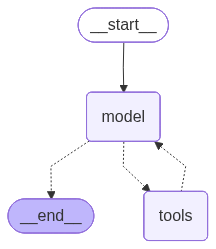

In [6]:

from langchain.chat_models import init_chat_model
from deep_agents_from_scratch.todo_tools import write_todos, read_todos
from deep_agents_from_scratch.state import DeepAgentState
from langchain.agents import create_agent
from langchain.tools import tool
from IPython.display import Image

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result
model = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai", timeout=30, temperature=0)
tools = [write_todos, web_search, read_todos]

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# Create agent
agent = create_agent(
    model,
    tools,
    system_prompt=TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SIMPLE_RESEARCH_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
# Example usage
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me a short summary of the Model Context Protocol (MCP).",
            }
        ],
        "todos": [],
    }
)



In [8]:
from utils import format_messages
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me a short summary of the Model Context Protocol (MCP).                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "status": "pending",                                                                                      │
│       "content": "Research the Model Context Protocol (MCP) and provide a short summary."                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 7ae63ed3-7da6-4dea-8e24-0c24734490aa                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research the Model Context Protocol (MCP) and provide a short summary.',     │
│ 'status': 'pending'}]                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: c18f1c2c-4ff2-445e-b5bc-f19aaa2fd792                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Research the Model Context Protocol (MCP) and provide a short summary. (pending)                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP) summary"                                                               │
│ }                                                                                                               │
│    ID: f98db7f4-a764-4d95-8e7b-eeeb618f15f6                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research the Model Context Protocol (MCP) and provide a short summary.",                      │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 20c05a5b-897a-49cf-a67c-bd5307508120                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research the Model Context Protocol (MCP) and provide a short summary.',     │
│ 'status': 'completed'}]                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed by Anthropic. It serves as a            │
│ standardized communication layer that enables AI models to seamlessly integrate with external systems such as   │
│ tools, databases, and other services. MCP simplifies the process of connecting AI assistants to external        │
│ services by providing a unified language for data exchange, allowing AI models to access and utilize data from  │
│ various sources in a consistent and efficient manner.                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
result

{'messages': [HumanMessage(content='Give me a short summary of the Model Context Protocol (MCP).', additional_kwargs={}, response_metadata={}, id='72e0a794-c23c-43b5-b906-daa954a3e819'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_todos', 'arguments': '{"todos": [{"status": "pending", "content": "Research the Model Context Protocol (MCP) and provide a short summary."}]}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc7f0-432e-7a70-baa4-bb9f13af77b1-0', tool_calls=[{'name': 'write_todos', 'args': {'todos': [{'status': 'pending', 'content': 'Research the Model Context Protocol (MCP) and provide a short summary.'}]}, 'id': '7ae63ed3-7da6-4dea-8e24-0c24734490aa', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 804, 'output_tokens': 37, 'total_tokens': 841, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(cont